#                                                       PROJET M1 2025 : DVF 

## Introduction

L’immobilier est un secteur clé de l’économie, et la prédiction des prix des biens immobiliers est un enjeu majeur pour les acheteurs, vendeurs et professionnels du domaine. 

Dans ce projet, nous nous intéressons à l’analyse des données issues de la **base DVF (Demandes de Valeurs Foncières)**, qui recense les transactions immobilières en France.

L’objectif de ce projet est de développer **un modèle de régression** permettant de prédire le prix d’un appartement en fonction de ses caractéristiques (surface, localisation, nombre de pièces, etc.) au travers des librairies `pandas`, `matplotlib`, `sklearn` et `scipy`. 

Notre démarche consistera à explorer les données issues de la base DVF, à identifier les variables pertinentes, puis à concevoir notre modèle afin d’estimer au mieux le prix des appartements.

Ce rapport présente ainsi les différentes étapes du projet, en commençant par une exploration des données, suivie de la préparation et de la sélection des features pertinentes, pour aboutir à la mise en place et à l’évaluation du modèle de prédiction.




In [39]:
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from math import *
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.metrics import *

print("- Numpy version:", np.__version__)
print("- matplotlib version :", mpl.__version__)
print("- Pandas version:", pd.__version__)
print("- Seaborn version:", sns.__version__)
print("- Sklearn version :",sklearn.__version__)

- Numpy version: 2.2.2
- matplotlib version : 3.10.1
- Pandas version: 2.2.3
- Seaborn version: 0.13.2
- Sklearn version : 1.6.1


## 1. Exploration de la base DVF 

Avant de commencer la modélisation, il est essentiel d’explorer le jeu de données.  

Cette première analyse nous permet de :  
- Prendre en main le contenu de la base et identifier les variables disponibles.  
- Observer la **taille du dataset** et vérifier la présence éventuelle de valeurs manquantes ou aberrantes.  
- Étudier quelques **statistiques descriptives** pour mieux appréhender la répartition des données.  
- Se familiariser avec les principales variables et identifier celles qui pourraient être pertinentes pour la modélisation.  
- Analyser des **corrélations** ou chercher des relations de causalité entre les différentes caractéristiques des logements et leur prix.  

Cette exploration nous aidera à orienter les étapes suivantes, notamment le prétraitement des données et la sélection des variables les plus influentes sur le prix des appartements.

###   1.1 Vue d'ensemble

Cette partie se consacre à l'exploration de la base DVF.

Certaines caractéristiques de cette base:

- Les transactions sont de type `appartement` ou `maison`.

- Contient uniquement les transactions _unitaires_, c'est-à-dire où un seul logement est vendu (par opposition à la situation où un gros investisseur achète une résidence entière).

- Contient uniquement les transactions ayant lieu en France métropolitaine.

- Contient uniquement les transactions à plus de 10 000 € (on considère les autres comme non-fiables).

- Contient uniquement les attributs suivants:
  - 'code_departement' : type `str`, représentant le numéro de département où a eu lieu la transaction (p.ex. `'75'` pour une transaction à Paris)
  - 'code_postal' : type `str`, indiquant le code postal de la transaction.  
  - 'type_local' : type `str`, précisant si le bien est une **maison** ou un **appartement**.  
  - 'surface_reelle_bati' : type `float`, la surface (en m²) de l'habitation.
  - 'nombre_pieces_principales' : type `float`, le nombre de pièces de l'habitation (chambre, salon, etc.)
  - 'surface_terrain' : type `float`, la surface du terrain (jardin, etc., en m²). `NaN` si pas de terrain.
  - 'longitude', 'latitude' : type `float`, les coordonnées GPS de l'habitation.
  - 'valeur_fonciere' : la valeur, en €, à laquelle la transaction a été enregistrée chez le notaire.
  - 'date_mutation' : type `str` ou `datetime`, précisant la **date à laquelle l’achat a été effectué**.  


In [40]:
# On charge la base de données.
# L'option dtype={'code_departement':'str'} indique que le code du département doit être traité comme une 
# chaîne de caractère. Ça permet d'éviter des bugs de typage avec la Corse (20A et 20B)).
dvf = pd.read_csv('./DVF_train.csv', dtype={'code_departement':'str'})

In [41]:
dvf

,date_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,2023-08-03,165410.0000,94160.0000,94,Appartement,17.0000,1.0000,NaN,2.4166,48.8405
1,2023-05-23,170900.0000,78300.0000,78,Appartement,80.0000,4.0000,NaN,2.0408,48.9269
2,2023-05-31,16000.0000,16000.0000,16,Appartement,20.0000,1.0000,NaN,0.1709,45.6513
3,2023-06-29,240000.0000,65400.0000,65,Appartement,75.0000,3.0000,621.0000,-0.0689,42.9883
4,2023-02-16,522000.0000,84400.0000,84,Maison,165.0000,5.0000,1000.0000,5.3846,43.9111
...,...,...,...,...,...,...,...,...,...,...
703768,2023-01-03,60000.0000,30000.0000,30,Appartement,22.0000,1.0000,NaN,4.3968,43.8542
703769,2023-04-07,250000.0000,46230.0000,46,Maison,140.0000,4.0000,500.0000,1.5468,44.3443
703770,2023-05-24,558000.0000,17139.0000,17,Maison,135.0000,6.0000,657.0000,-1.0563,46.1924
703771,2023-04-11,360000.0000,44230.0000,44,Maison,74.0000,4.0000,363.0000,-1.4899,47.1985


La base de données contient 703773 observations de dimension 10.

In [42]:
pd.set_option('display.float_format', lambda x: '%.f' % x)
dvf[["surface_reelle_bati", "nombre_pieces_principales", "surface_terrain", "valeur_fonciere"]].describe()

,surface_reelle_bati,nombre_pieces_principales,surface_terrain,valeur_fonciere
count,703672,703672,515266,703773
mean,85,4,981,347307
std,48,2,4440,682211
min,1,0,1,10000
25%,52,2,250,123000
50%,80,4,500,202000
75%,106,5,866,330000
max,1250,95,713830,9900000


####  Valeurs foncières moyennes des appartement et maisons

In [43]:
pd.concat([dvf.loc[dvf['type_local'] == 'Appartement', 'valeur_fonciere'].describe().apply(lambda x: format(x, 'f')),
         dvf.loc[dvf['type_local'] == 'Maison', 'valeur_fonciere'].describe().apply(lambda x: format(x, 'f'))], axis=1, keys=['Appartement', 'Maison'])

,Appartement,Maison
count,244372.000000,459401.000000
mean,443318.424661,296235.725377
std,988497.973923,430929.869826
min,10000.000000,10000.000000
25%,115000.000000,130000.000000
50%,187000.000000,210000.000000
75%,330000.000000,331400.000000
max,9850000.000000,9900000.000000


On remarque que la valeur foncière des appartements est en moyenne plus élevée que celle des maisons, avec un prix moyen de 443 318 € pour un appartement contre 296 235 € pour une maison.

Cette observation est renforcé par l'écart-type, qui est significativement plus élevé pour les appartements. Un écart-type important indique une grande variabilité des prix des appartements, suggérant que les prix peuvent fluctuer énormément.

### 1.2 Exploration des features 

Lorsqu’on cherche à expliquer le prix d’un logement, certains facteurs viennent naturellement à l’esprit. L’emplacement du bien est souvent un critères, influençant fortement sa valeur. Ensuite, des caractéristiques comme la surface habitable, la présence d’un terrain et le nombre de pièces jouent également un rôle essentiel. 
Ces éléments constituent une première base de réflexion pour l’exploration des données.

#### Distribution de la valeur foncière 
Tout d'abord, analysons la répartition des prix des biens immobiliers.

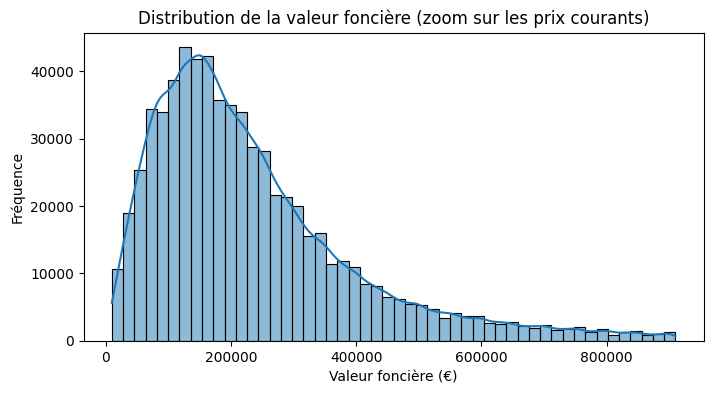

In [44]:
plt.figure(figsize=[8,4])
valeur_max = dvf['valeur_fonciere'].quantile(0.95) # on enlève les valeurs extremes pour se concentrer sur les prix courants
sns.histplot(dvf[dvf['valeur_fonciere'] <= valeur_max]['valeur_fonciere'], bins=50 , kde = True)
plt.title('Distribution de la valeur foncière (zoom sur les prix courants)')
plt.xlabel('Valeur foncière (€)')
plt.ylabel('Fréquence')

plt.show()

- On observe qu'un grand nombre de bien sont vendu aux alentour de 170K-300K. 

- Plus la valeur foncière augmente et plus le nombre de biens vendus diminue.
=> Les biens sont en moyenne vendu dans les tranches de 150-300k

#### Distribution des prix par département

Nous examinons la répartition des valeurs foncières par département pour identifier les tendances et les départements les plus réputés pour leurs prix élevés, afin de mieux comprendre l'impact des différentes caractéristiques géographiques sur la valeur des biens immobiliers.

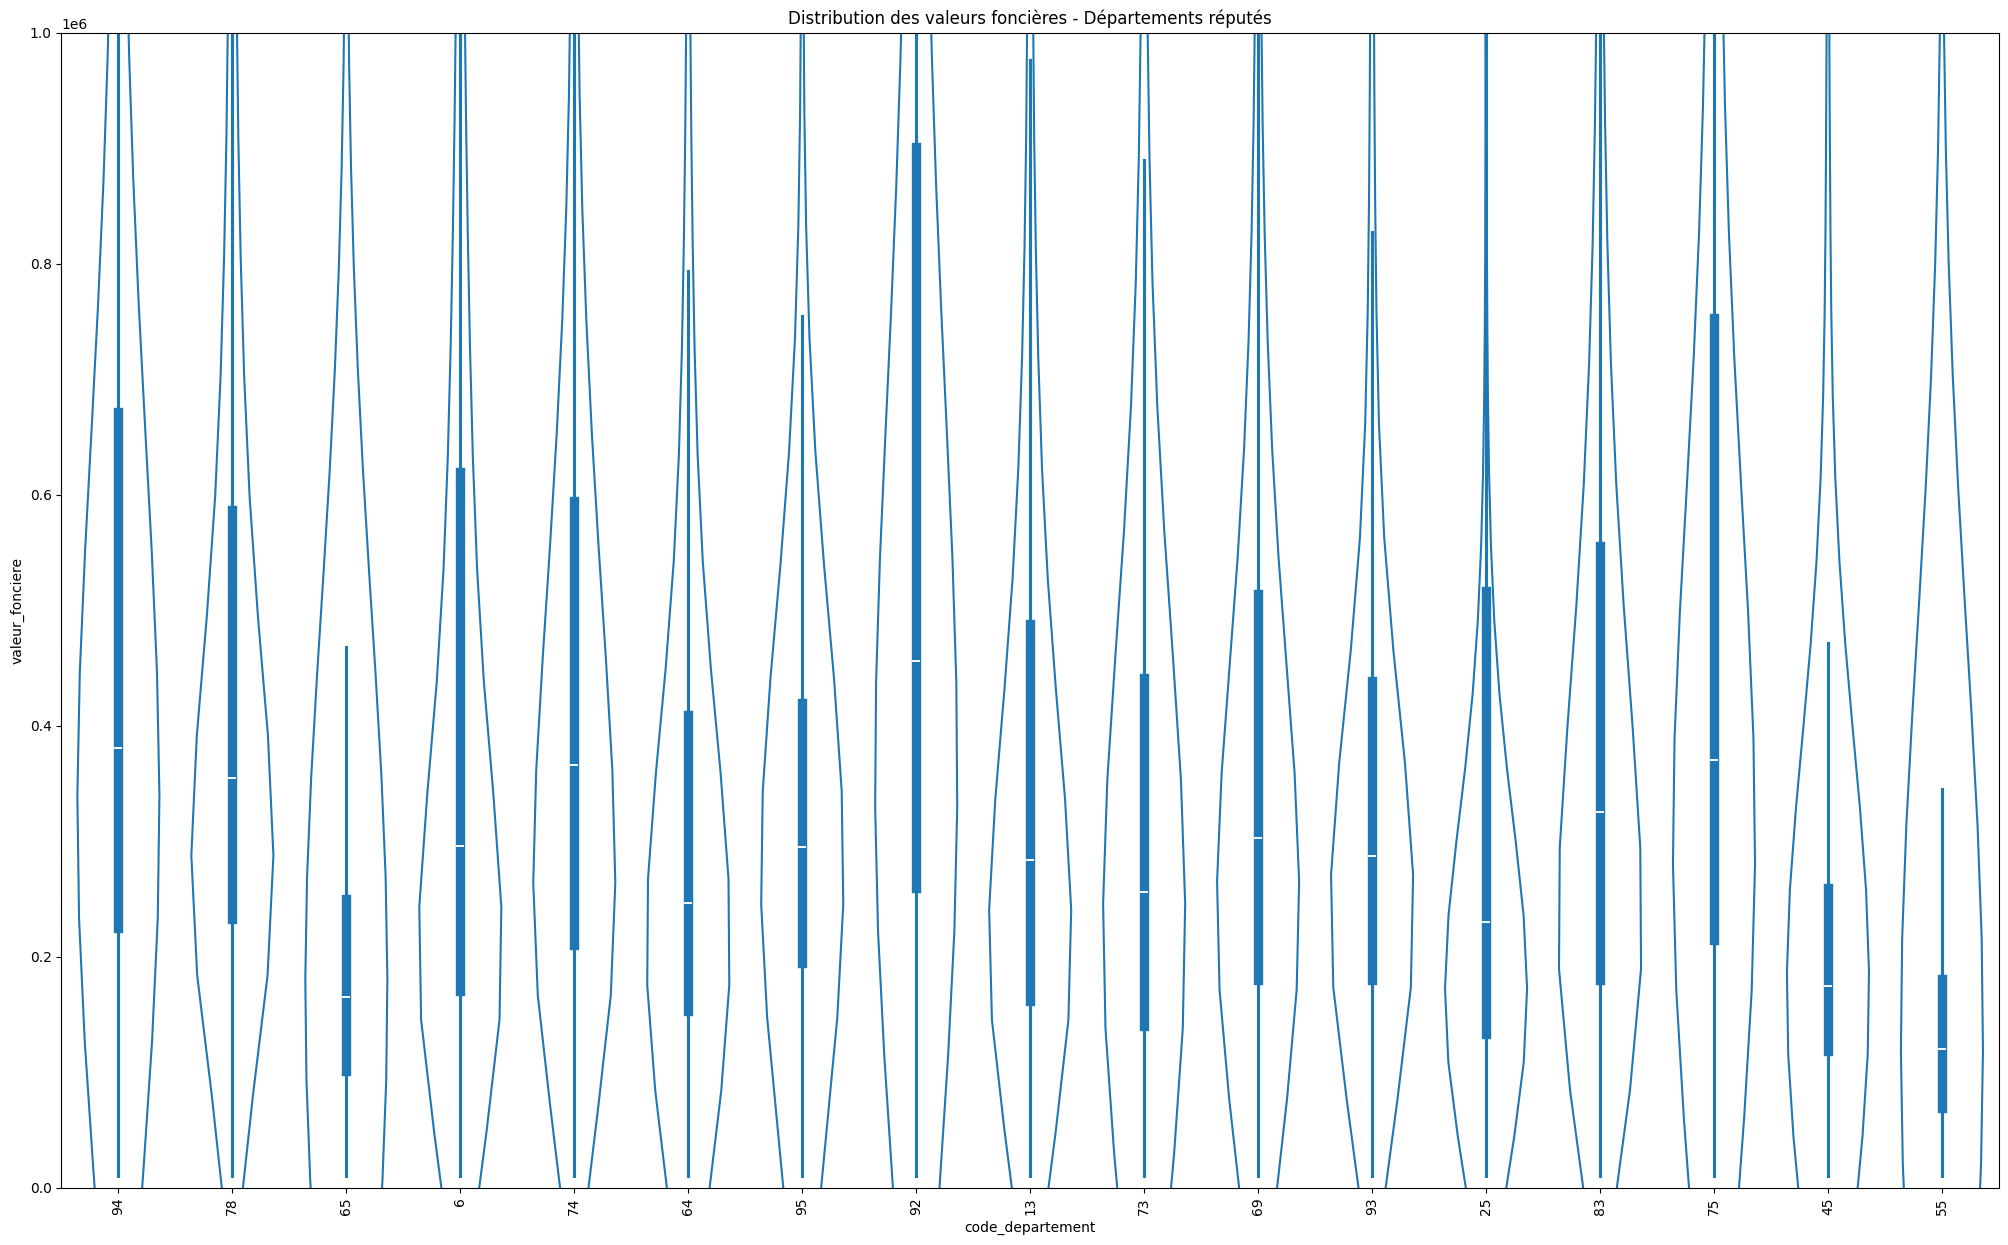

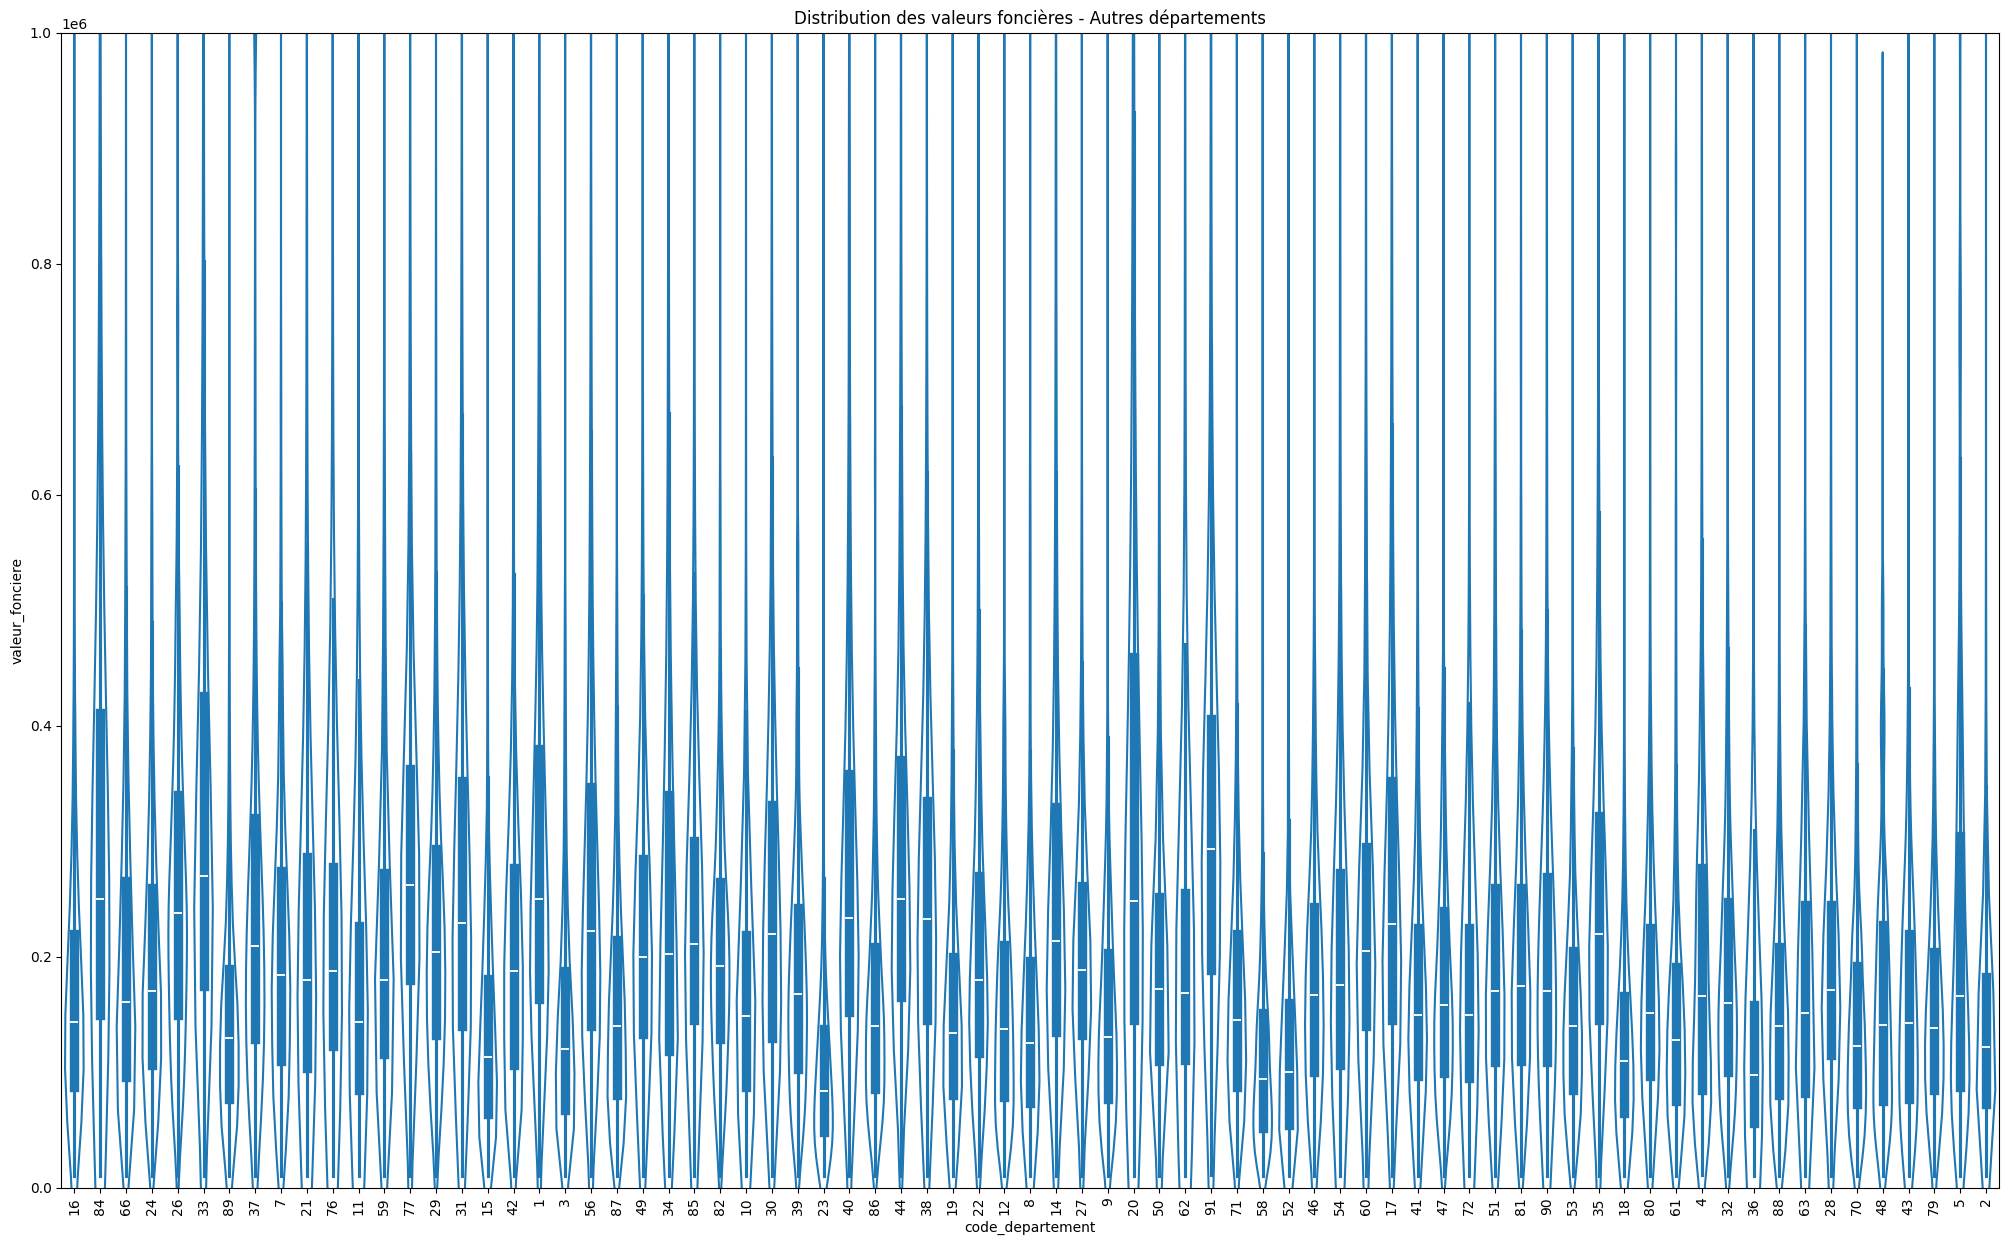

In [45]:
valeur_fonciere_par_departement = dvf.groupby("code_departement")["valeur_fonciere"].mean()

seuil = 450_000
departements_reputes = valeur_fonciere_par_departement[valeur_fonciere_par_departement > seuil].index
departements_autres = valeur_fonciere_par_departement[valeur_fonciere_par_departement <= seuil].index

dvf_reputes = dvf[dvf["code_departement"].isin(departements_reputes)]
dvf_autres = dvf[dvf["code_departement"].isin(departements_autres)]

plt.figure(figsize=(25, 15))
sns.violinplot(data=dvf_reputes, x="code_departement", y="valeur_fonciere", density_norm="width",fill=False,gap = 0.1)
plt.ylim(0, 1_000_000)
plt.xticks(rotation=90)
plt.title("Distribution des valeurs foncières - Départements réputés")
plt.show()

plt.figure(figsize=(25, 15))
sns.violinplot(data=dvf_autres, x="code_departement", y="valeur_fonciere", density_norm="width",fill=False,gap = 0.1)
plt.ylim(0, 1_000_000)
plt.xticks(rotation=90)
plt.title("Distribution des valeurs foncières - Autres départements")
plt.show()

Ce graphique illustre la distribution des valeurs foncières pour différents départements.

Pour le violin plot des departement reputés , on observe que Paris(75) et les Hauts de seine (92) présentent une forte concentration des transactions à des valeurs élevées, avec des médianes significativement plus haute que les autres. 

D’autres départements affichent une distribution plus large, suggérant une plus grande variabilité des prix. 

Pour le violin plot des autres départements , on observe des valeurs foncières plus basses et plus dispersées, avec moins de transactions pour des montants élevé , contrairement aux départements les plus cotés, les médianes sont plus basses.

Ainsi on en deduit que le code departement a un role dans la distribution des valeurs foncières.

Ce graphique a été réalisé par chatGPT , après s'etre renseigné sur l'existence des violins plot , nous avons donné le prompt suivant 
"Je veux faire un violin plot des valeurs foncières en fonction des départements. Je veux séparer les départements en deux groupes : ceux où la valeur foncière moyenne dépasse 450 000 € et les autres. Peux-tu me donner un code en Python avec Seaborn pour représenter ces distributions ?"

#### Distribution des prix en fonction de la position géographique

<Axes: xlabel='longitude', ylabel='latitude'>

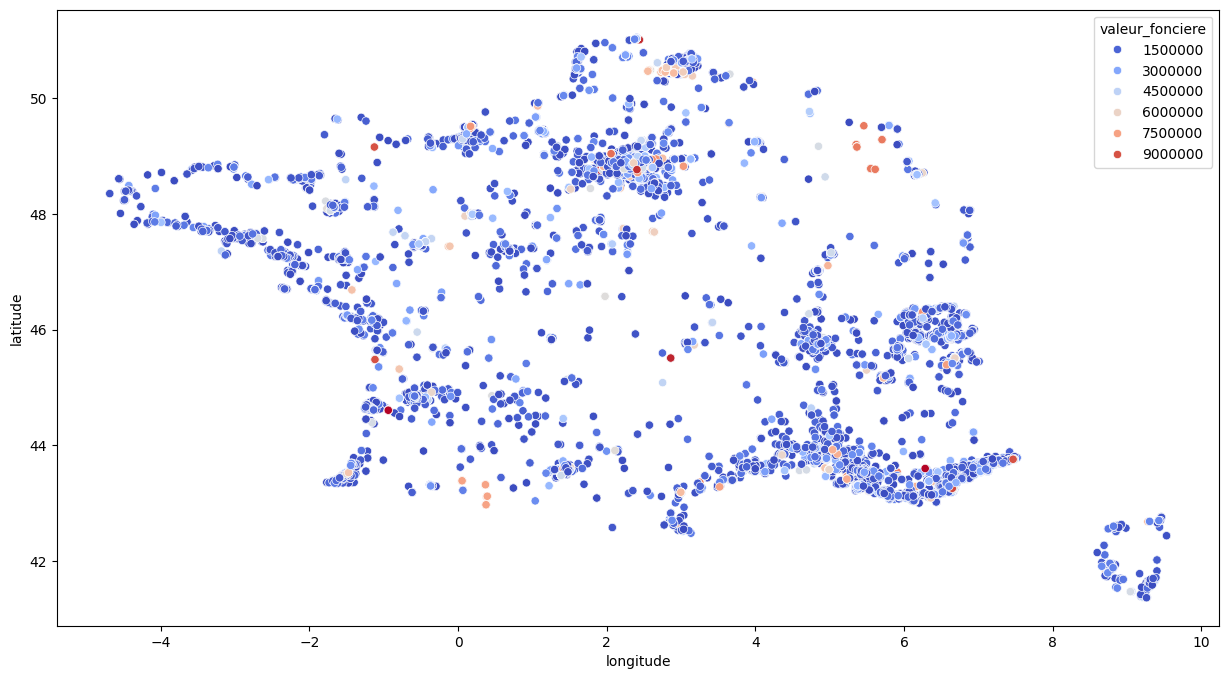

In [46]:
dvf_filtered = dvf.loc[(dvf['valeur_fonciere'] >= 1_000_000) & (dvf['valeur_fonciere'] <= 10_000_000)]
plt.figure(figsize=(15,8))
sns.scatterplot(x = "longitude" , y = "latitude" , data = dvf_filtered , hue = "valeur_fonciere" , palette="coolwarm")

Les transactions immobilières haut de gamme (1M€) sont fortement concentrées dans certaines zones urbaines et côtières, notamment à Paris, Lille, la région bordelaise, ainsi que dans les zones côtières comme Marseille et la Corse.

La localisation géographique joue un rôle dans le prix des biens immobiliers, mais elle n'est pas suffisamment discriminante pour prédire précisément les valeurs immobilières.

#### Repartition des prix en fonction de la surface habitable

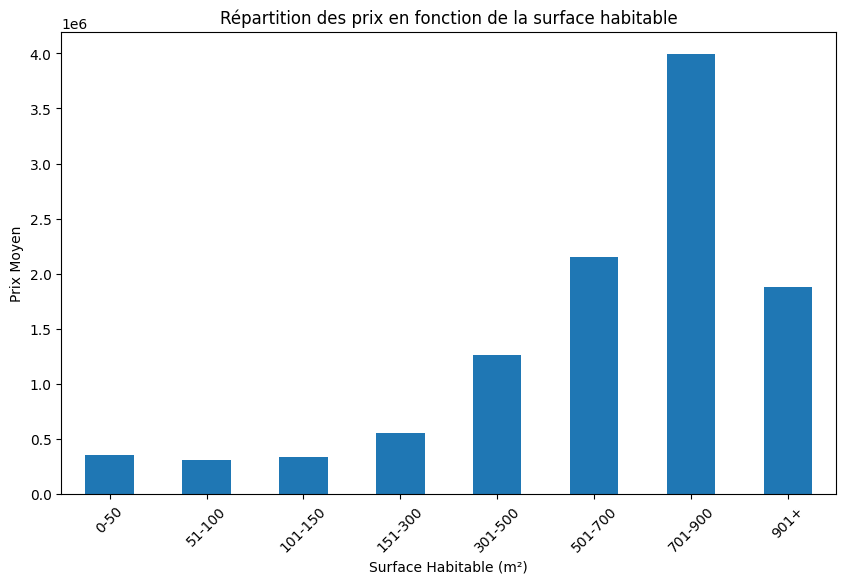

In [47]:
#### Repartition des prix en fonction de la surface habitable

bins = [0, 50, 100, 150, 300, 500, 700, 900, dvf['surface_reelle_bati'].max()]
labels = ['0-50', '51-100', '101-150', '151-300', '301-500', '501-700', '701-900', '901+']

plt.figure(figsize=(10, 6))

prix_par_surface = dvf.groupby(pd.cut(dvf['surface_reelle_bati'], bins=bins, labels=labels), observed=False)['valeur_fonciere'].mean()
prix_par_surface.plot(kind='bar')

plt.title('Répartition des prix en fonction de la surface habitable')
plt.xlabel('Surface Habitable (m²)')
plt.ylabel('Prix Moyen')
plt.xticks(rotation=45)

plt.show()

On observe que plus la surface habitable est élevé plus le prix risque d'augmenter. 

On a donc une corrélation entre ces deux features. Mais la différence entre les (700-900 m²) et (+900 m²) montre que les logements de très grandes surfaces (+900 m²) ne suivent pas nécessairement la même tendance de hausse des prix, ce qui pourrait être dû à une demande plus faible, une offre plus restreinte ou des spécificités du marché immobilier pour ces biens. 

### Repartition des prix en fonction de la présence d'un terrain

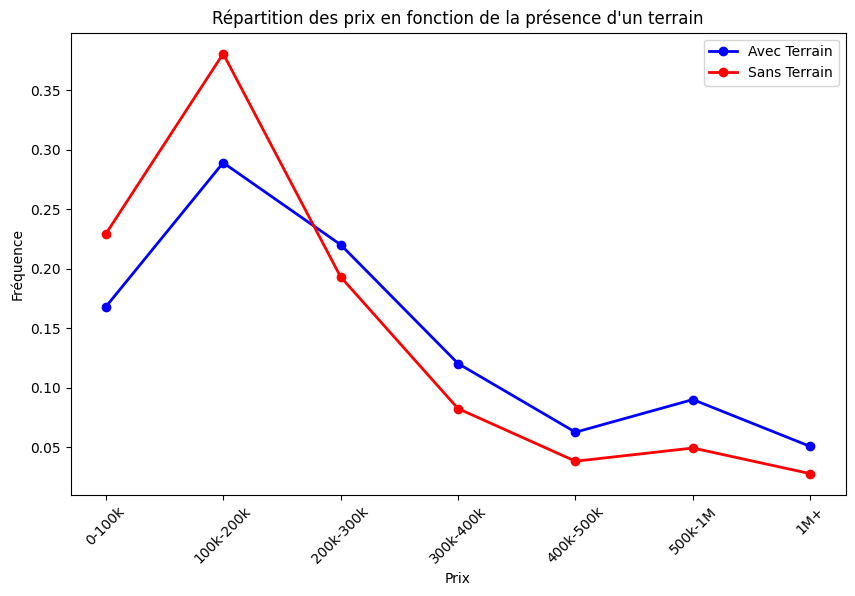

In [48]:
#### Repartition des prix en fonction de la presence d'un terrain

bins = [0, 100000, 200000, 300000, 400000, 500000, 1000000, dvf['valeur_fonciere'].max()]  # Tranches de prix
labels = ['0-100k', '100k-200k', '200k-300k', '300k-400k', '400k-500k', '500k-1M', '1M+']

plt.figure(figsize=(10, 6))

freq_surface_avec_terrain = pd.cut(dvf.loc[dvf['surface_terrain'].notna(), 'valeur_fonciere'], bins=bins, labels=labels).value_counts(normalize=True).sort_index()
freq_surface_sans_terrain = pd.cut(dvf.loc[dvf['surface_terrain'].isna(), 'valeur_fonciere'], bins=bins, labels=labels).value_counts(normalize=True).sort_index()

plt.plot(freq_surface_avec_terrain.index, freq_surface_avec_terrain.values, label='Avec Terrain', marker='o', linestyle='-', color='blue', linewidth=2)
plt.plot(freq_surface_sans_terrain.index, freq_surface_sans_terrain.values, label='Sans Terrain', marker='o', linestyle='-', color='red', linewidth=2)

plt.title("Répartition des prix en fonction de la présence d'un terrain")
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.legend()

plt.xticks(rotation=45)
plt.show()

On observe que :
- Les biens sans terrain dominent la tranche 100K-200K
- Les biens avec terrain sont surreprésentés dans les segments supérieurs à 400K

La relation prix-terrain n'est pas linéaire et varie selon les segments de marché, cependant la présence d'un terrain est un predicteur  que l'on doit garder.

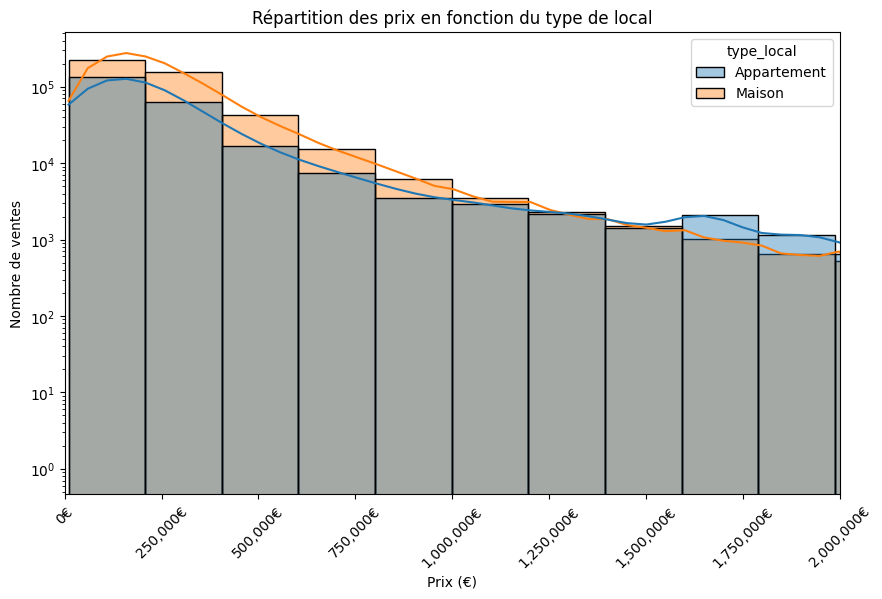

In [49]:
#### Repartition des prix en fonction du type local
dvf_filtre = dvf[(dvf["valeur_fonciere"] > 0) & (dvf["valeur_fonciere"] <= 2_000_000)] #filtrage des valeurs trop hautes

plt.figure(figsize=(10,6))
sns.histplot(data=dvf, x="valeur_fonciere", hue="type_local", kde=True, bins=50,alpha = 0.4)

# Ajouter des labels
plt.xlabel("Prix (€)")
plt.xlim(0, 2_000_000)
plt.ylabel("Nombre de ventes")
plt.yscale("log")
plt.xticks(ticks=plt.xticks()[0], labels=[f"{int(x):,}€" for x in plt.xticks()[0]],rotation=45)
plt.title("Répartition des prix en fonction du type de local")
plt.show()

Les barres grises montre la **distribution globale des ventes** selon les tranches de prix.
On constate que le nombre de transactions est nettement plus élevé pour les biens les moins chers (0-600K) et diminue progressivement à mesure que le prix augmente.

Dans les tranches de prix les plus élevées, les ventes enregistrées concernent plus les appartements, ce qui suggère une absence ou une très faible présence de maisons dans ces catégories de prix.

**Les courbes de densité des appartements et des maisons suivent une tendance similaire.**

Ce graphique met en évidence une forte présence des appartements parmi les ventes les plus cher, tandis que les maisons sont plus diversifiées en termes de prix.

### Matrice des corrélations :

Suite à nos observations , nous allons tracer une matrice de corrélations qui nous permettra de valider nos hypothèses....

<Axes: >

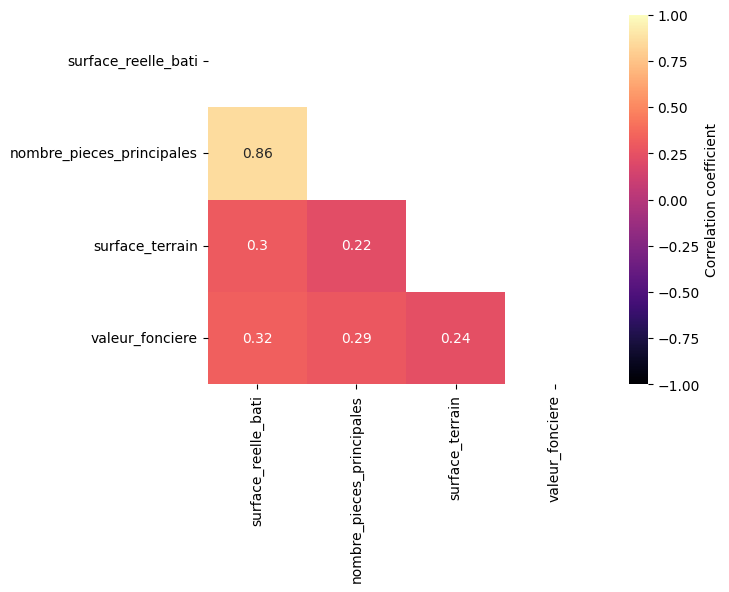

In [50]:
dvf_reduced = dvf[["surface_reelle_bati", "nombre_pieces_principales", "surface_terrain", "valeur_fonciere"]]
corr_matrix = dvf_reduced.corr(method='spearman')
pd.set_option('display.float_format', '{:.4f}'.format)
corr_matrix
mask = np.triu(np.ones_like(corr_matrix,dtype=bool))
sns.heatmap(corr_matrix,vmin = -1 , vmax = 1 , annot = True, cmap = "magma", mask = mask ,cbar_kws={'label': 'Correlation coefficient'})

La matrice de corrélation révèle des relations modérées entre les différentes variables et la valeur foncière.

La variable surface réelle bâtie présente la corrélation la plus forte avec le prix, atteignant un coefficient de 0.32, suivie du nombre de pièces principales avec 0.29. 

Cela indiquent que ces deux variables ont une certaine influence sur la valeur foncière, mais cela reste relativement faible. 

Les variables surface terrain et valeur foncière montrent également une corrélation modérée de 0.24, suggérant qu'il existe une faible influence de la superficie du terrain sur le prix.

Dans l'ensemble, les corrélations observées sont **faibles à modérées**, ce qui suggère que la relation entre ces variables et la valeur foncière est probablement **non linéaire**. Il existe peut etre des interactions plus complexes entre ces variables, ou des effets non linéaires, qui expliquerait mieux la variation des prix.

Pour approfondir cette analyse, nous allons utiliser la librairie Seaborn afin de tracer différents graphiques. Plus précisément, nous utiliserons la fonction pairplot pour visualiser les relations entre les variables. Cela nous permettra de déterminer si ces relations sont effectivement non linéaires, ou si notre analyse précédente a omis certains éléments.

### 1.3 Visualisation des relations non Linéaires entre les Variables avec Seaborn

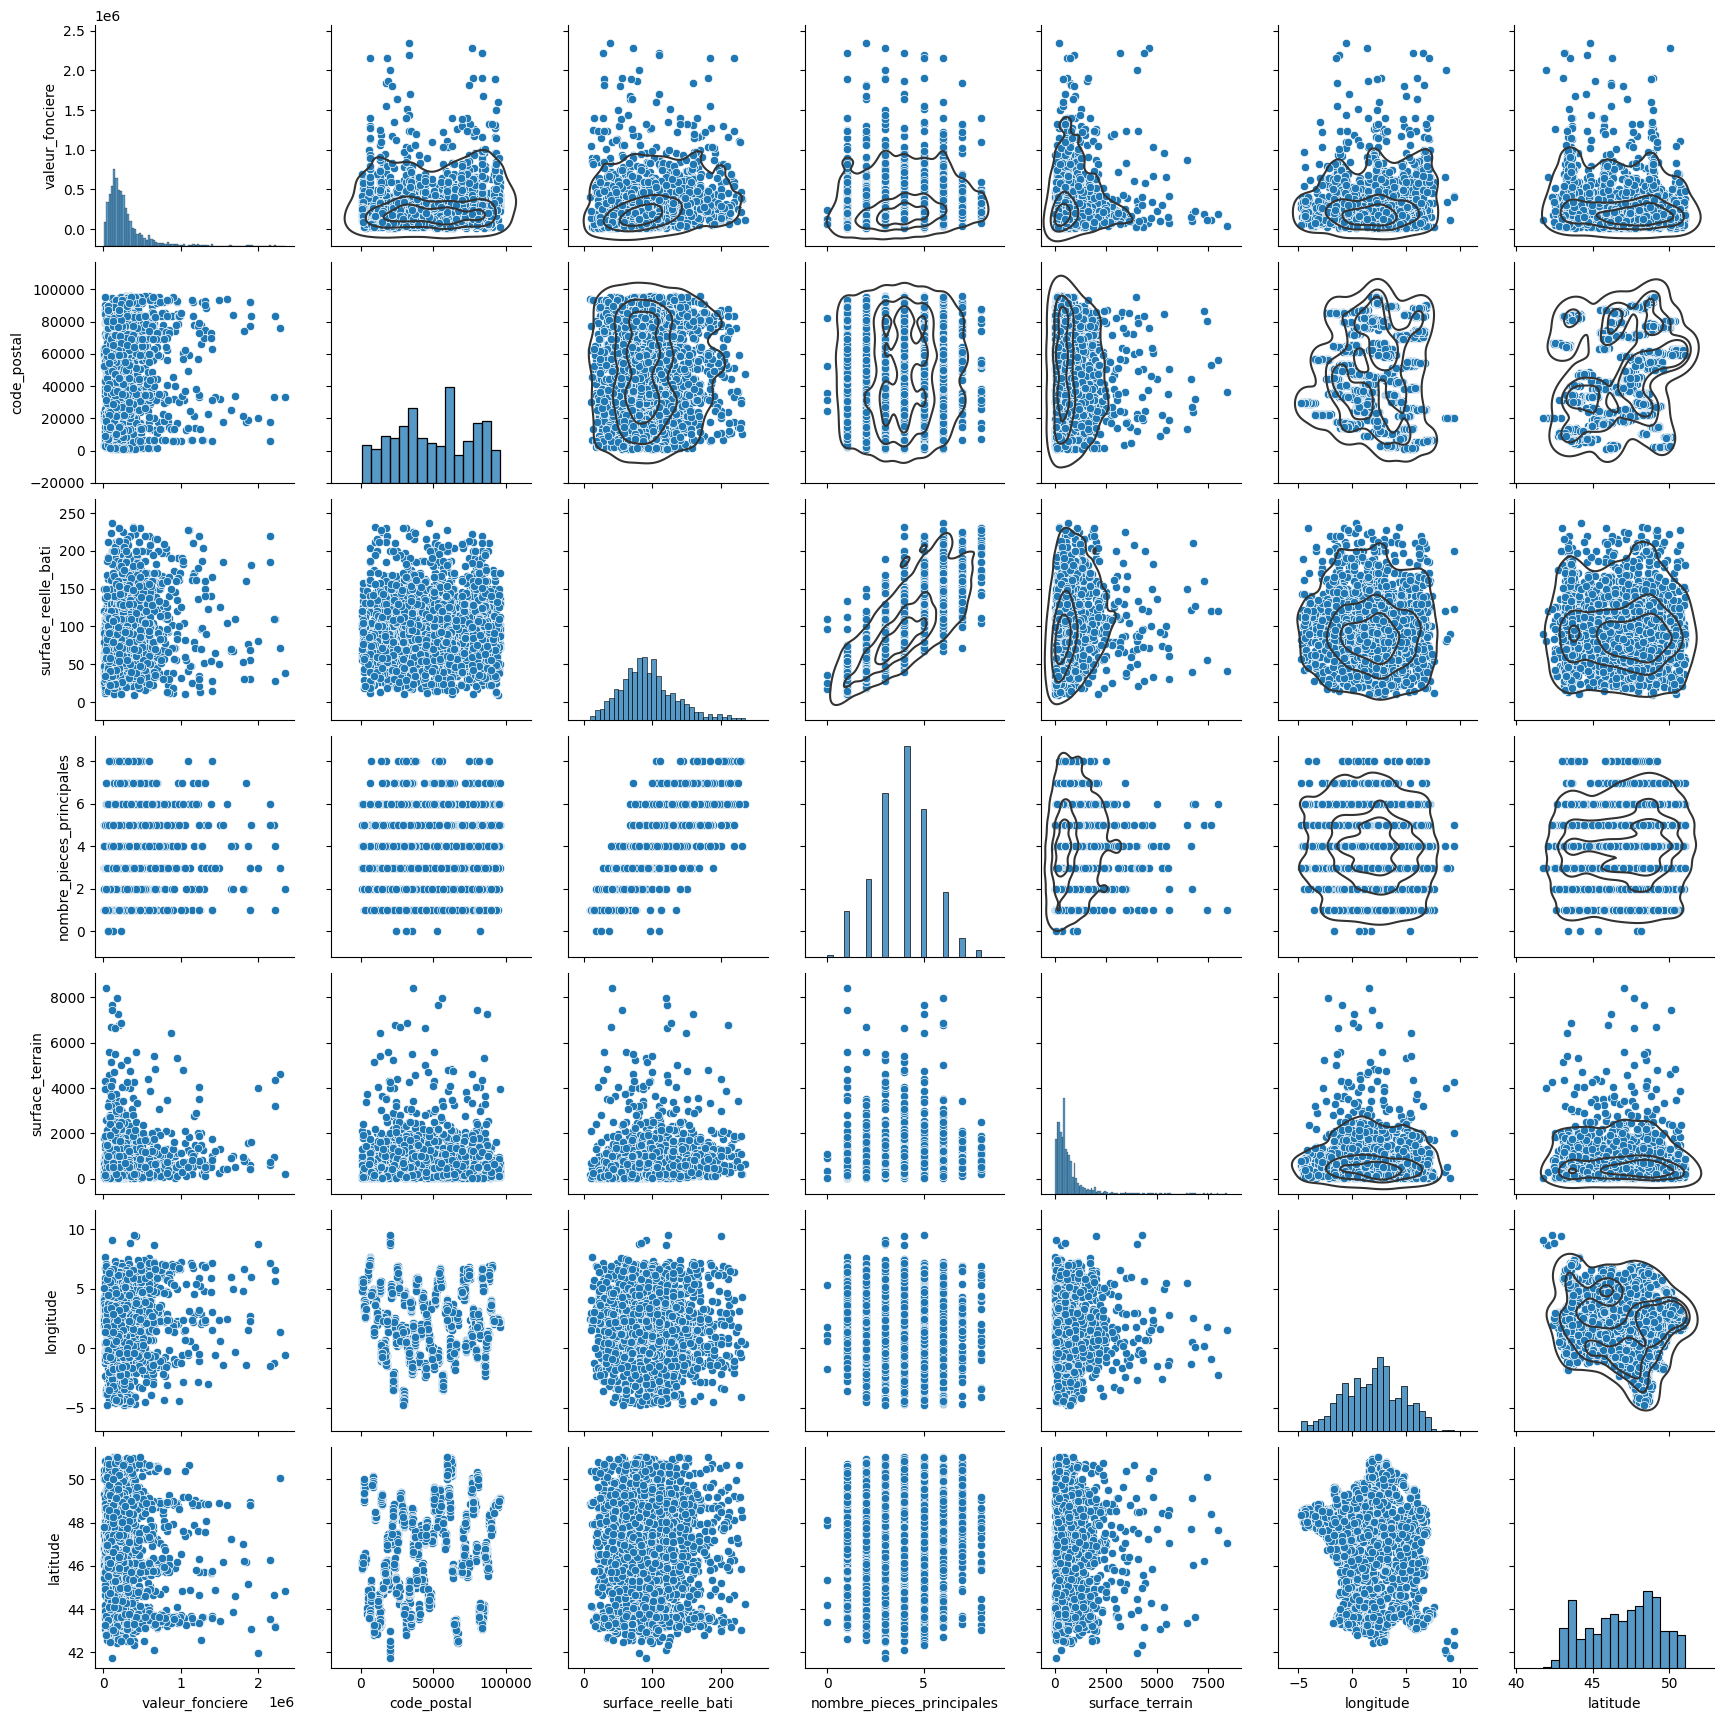

In [51]:
numeric_columns = dvf.select_dtypes(include=[np.number]).columns
numeric_dvf = dvf[numeric_columns]
dvf_sample = numeric_dvf.sample(frac=0.005)
dvf_sample = dvf_sample[(np.abs(stats.zscore(dvf_sample, nan_policy='omit')) < 3).all(axis=1)]
g = sns.pairplot(dvf_sample)
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

En regardant les graphiques où valeur_foncière est en abscisse ou en ordonnée, on remarque que l'on a pas de relation linéaires directe entre la valeur foncière et les différentes variables (surface_reel_bati , nombre_pieces_principales , surface_terrain). 

Cela nous permet de mieux comprendre les coefficients de corrélations que l'on a obtenu ci dessus.

On observe egalement des **effets de saturation** , pour certaines variables comme surface_terrain, il semble y avoir une forte concentration de points pour les petites surfaces et quelques points très éloignés pour les grandes surfaces.

On remarque bien sur les différentes graphique que à partir d'un certain point augmenter la surface du terrain n'influencent plus sur la valeur foncière.

## 2. Feature engineering

Après cette phase d'exploration , nous allons préparer notre jeu de données 
en éliminant les données aberrantes , car ces anomalies pourrait affecter les performances de notre modèle.

La Feature Engineering (ou ingénierie des caractéristiques) est **une étape clé** du Machine Learning qui consiste à transformer les données brutes en un format optimal pour améliorer les performances du modèle.

#### 2.1 Analyse des données manquantes

In [52]:
print(dvf["surface_reelle_bati"].isnull().any())
print(dvf["nombre_pieces_principales"].isnull().any())
print(dvf["surface_terrain"].isnull().any())
print(dvf["valeur_fonciere"].isnull().any())
print(dvf["longitude"].isnull().any())
print(dvf["latitude"].isnull().any())
print(dvf["code_postal"].isnull().any())

True
True
True
False
True
True
True


On voit qu'il y'a des valeurs null dans les colonnes surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude

In [53]:
nan_proportion = dvf.isna().mean() 
print(nan_proportion)

date_mutation               0.0000
valeur_fonciere             0.0000
code_postal                 0.0001
code_departement            0.0000
type_local                  0.0000
surface_reelle_bati         0.0001
nombre_pieces_principales   0.0001
surface_terrain             0.2679
longitude                   0.0080
latitude                    0.0080
dtype: float64


On observe que les proportions de NaN dans les colonnes surface_relle_bati ,nombre_pieces_principales,longitude,latitude sont faibles , on peut donc tout simplement les supprimer de notre jeu de données sans que ca n'ai trop d'impact.

In [54]:
# Supprimer les lignes contenant des NaN dans les colonnes sélectionnées
dvf = dvf.dropna(subset=['surface_reelle_bati', 'nombre_pieces_principales', 'longitude', 'latitude','code_postal'])

Cependant la colonne surface_terrain contient beaucoup de valeurs NaN , on modifiera les NaN par des 0.

In [55]:
dvf = dvf.dropna(subset=["surface_reelle_bati"])
dvf.loc[dvf["surface_terrain"].isnull(), "surface_terrain"] = 0

In [56]:
dvf

,date_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,2023-08-03,165410.0000,94160.0000,94,Appartement,17.0000,1.0000,0.0000,2.4166,48.8405
1,2023-05-23,170900.0000,78300.0000,78,Appartement,80.0000,4.0000,0.0000,2.0408,48.9269
2,2023-05-31,16000.0000,16000.0000,16,Appartement,20.0000,1.0000,0.0000,0.1709,45.6513
3,2023-06-29,240000.0000,65400.0000,65,Appartement,75.0000,3.0000,621.0000,-0.0689,42.9883
4,2023-02-16,522000.0000,84400.0000,84,Maison,165.0000,5.0000,1000.0000,5.3846,43.9111
...,...,...,...,...,...,...,...,...,...,...
703768,2023-01-03,60000.0000,30000.0000,30,Appartement,22.0000,1.0000,0.0000,4.3968,43.8542
703769,2023-04-07,250000.0000,46230.0000,46,Maison,140.0000,4.0000,500.0000,1.5468,44.3443
703770,2023-05-24,558000.0000,17139.0000,17,Maison,135.0000,6.0000,657.0000,-1.0563,46.1924
703771,2023-04-11,360000.0000,44230.0000,44,Maison,74.0000,4.0000,363.0000,-1.4899,47.1985


On verifie tout de meme si l'on a pas oublié des valeurs manquantes.

In [57]:
print(dvf["surface_reelle_bati"].isnull().any())
print(dvf["nombre_pieces_principales"].isnull().any())
print(dvf["surface_terrain"].isnull().any())
print(dvf["valeur_fonciere"].isnull().any())
print(dvf["longitude"].isnull().any())
print(dvf["latitude"].isnull().any())
print(dvf["code_postal"].isnull().any())

False
False
False
False
False
False
False


Nous allons également regarder si notre jeu de données contient d'eventuelles doublons. La présence de doublons peut introduire une redondance dans les informations et fausser l'apprentissage du modèle.

In [58]:
has_duplicates = dvf.duplicated().any()
print(has_duplicates)

True


Par curiosité , nous allons afficher les lignes qui sont en doublons

In [59]:
doublons = dvf[dvf.duplicated()]
doublons

,date_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
1036,2023-02-06,1643439.6000,25000.0000,25,Appartement,65.0000,3.0000,887.0000,6.0062,47.2280
1373,2023-07-04,335160.0000,34080.0000,34,Appartement,82.0000,4.0000,81.0000,3.8196,43.6286
1704,2023-08-09,92967.0000,69270.0000,69,Appartement,67.0000,3.0000,0.0000,4.8636,45.8248
2308,2023-12-15,210000.0000,76480.0000,76,Appartement,33.0000,1.0000,1500.0000,0.8158,49.4314
3778,2023-12-06,1054000.0000,37200.0000,37,Appartement,62.0000,3.0000,0.0000,0.6948,47.3607
...,...,...,...,...,...,...,...,...,...,...
703653,2023-06-29,270000.0000,13003.0000,13,Appartement,46.0000,1.0000,125.0000,5.3767,43.3109
703681,2023-12-21,225000.0000,83300.0000,83,Appartement,20.0000,1.0000,30.0000,6.4663,43.5389
703710,2023-10-02,217300.0000,13920.0000,13,Appartement,32.0000,2.0000,387.0000,5.0087,43.4675
703756,2023-12-15,165000.0000,38150.0000,38,Appartement,62.0000,3.0000,0.0000,4.8031,45.3642


On observe que l'on a environ 2500 doublons dans le jeu de données , nous allons donc les retirer.

In [60]:
dvf.drop_duplicates(inplace=True)
has_duplicates = dvf.duplicated().any()
print(has_duplicates)
dvf

False


,date_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,2023-08-03,165410.0000,94160.0000,94,Appartement,17.0000,1.0000,0.0000,2.4166,48.8405
1,2023-05-23,170900.0000,78300.0000,78,Appartement,80.0000,4.0000,0.0000,2.0408,48.9269
2,2023-05-31,16000.0000,16000.0000,16,Appartement,20.0000,1.0000,0.0000,0.1709,45.6513
3,2023-06-29,240000.0000,65400.0000,65,Appartement,75.0000,3.0000,621.0000,-0.0689,42.9883
4,2023-02-16,522000.0000,84400.0000,84,Maison,165.0000,5.0000,1000.0000,5.3846,43.9111
...,...,...,...,...,...,...,...,...,...,...
703768,2023-01-03,60000.0000,30000.0000,30,Appartement,22.0000,1.0000,0.0000,4.3968,43.8542
703769,2023-04-07,250000.0000,46230.0000,46,Maison,140.0000,4.0000,500.0000,1.5468,44.3443
703770,2023-05-24,558000.0000,17139.0000,17,Maison,135.0000,6.0000,657.0000,-1.0563,46.1924
703771,2023-04-11,360000.0000,44230.0000,44,Maison,74.0000,4.0000,363.0000,-1.4899,47.1985


Un autre facteur important qui pourrait influencer notre modèle est la gestion des valeurs extrêmes (outliers). Ces valeurs peuvent fausser les prédictions, nous allons donc les détecter et les éliminer.

Pour ce faire , nous avons opter pour l'algorithme de **Isolation Forest**. Cet algorithme permet de repérer les points anormaux en les isolant via des arbres de décision. Ce qui a particulièrement retenu notre attention sur cette algorithme est sa capacité à intégrer des données géographiques (longitude, latitude). 

Grâce à ces informations, **Isolation Forest** peut mieux saisir les tendances des prix immobiliers dans des zones spécifiques, comme Paris ou les régions rurales.
Par exemple, un prix élevé dans une zone rurale sera vite identifié comme un outlier, contrairement à Paris où cela serait plus commun.

In [61]:
features = ["valeur_fonciere", "surface_reelle_bati", "longitude", "latitude"]
forest = IsolationForest(contamination=0.03)
dvf["outlier"] = forest.fit_predict(dvf[features])
outliers_dvf = dvf.loc[dvf["outlier"] == -1]
outliers_dvf

,date_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,outlier
6,2023-06-07,1300000.0000,6400.0000,6,Appartement,146.0000,3.0000,0.0000,6.9986,43.5536,-1
38,2023-04-07,1600000.0000,56360.0000,56,Maison,210.0000,8.0000,977.0000,-3.1314,47.2933,-1
49,2023-12-28,6960000.0000,78370.0000,78,Maison,81.0000,4.0000,137.0000,1.9573,48.8259,-1
73,2023-10-18,980000.0000,19100.0000,19,Appartement,226.0000,6.0000,0.0000,1.5315,45.1621,-1
106,2023-06-29,425000.0000,6250.0000,6,Maison,217.0000,5.0000,43.0000,6.9951,43.6008,-1
...,...,...,...,...,...,...,...,...,...,...,...
703519,2023-08-30,2225000.0000,83310.0000,83,Maison,370.0000,7.0000,500.0000,6.6066,43.2917,-1
703523,2023-10-20,1331140.0000,59130.0000,59,Maison,258.0000,8.0000,1150.0000,3.0301,50.6437,-1
703561,2023-06-22,1584000.0000,74340.0000,74,Appartement,30.0000,1.0000,858.0000,6.7255,46.0818,-1
703682,2023-10-12,2150000.0000,37360.0000,37,Maison,52.0000,3.0000,364.0000,0.6370,47.4844,-1


In [62]:
dvf = dvf[dvf['outlier'] == 1]
dvf = dvf.drop(columns=['outlier'])

In [63]:
dvf

,date_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,2023-08-03,165410.0000,94160.0000,94,Appartement,17.0000,1.0000,0.0000,2.4166,48.8405
1,2023-05-23,170900.0000,78300.0000,78,Appartement,80.0000,4.0000,0.0000,2.0408,48.9269
2,2023-05-31,16000.0000,16000.0000,16,Appartement,20.0000,1.0000,0.0000,0.1709,45.6513
3,2023-06-29,240000.0000,65400.0000,65,Appartement,75.0000,3.0000,621.0000,-0.0689,42.9883
4,2023-02-16,522000.0000,84400.0000,84,Maison,165.0000,5.0000,1000.0000,5.3846,43.9111
...,...,...,...,...,...,...,...,...,...,...
703768,2023-01-03,60000.0000,30000.0000,30,Appartement,22.0000,1.0000,0.0000,4.3968,43.8542
703769,2023-04-07,250000.0000,46230.0000,46,Maison,140.0000,4.0000,500.0000,1.5468,44.3443
703770,2023-05-24,558000.0000,17139.0000,17,Maison,135.0000,6.0000,657.0000,-1.0563,46.1924
703771,2023-04-11,360000.0000,44230.0000,44,Maison,74.0000,4.0000,363.0000,-1.4899,47.1985


#### Normalisation des données

Notre jeu de données contient des colonnes contenant des échelles de valeurs très différentes. Par exemple, la valeur foncière peut atteindre plusieurs millions d'euros, tandis que des caractéristiques comme le nombre de pièces ou la surface ont des valeurs beaucoup plus petites. 

Cette disparité dans les valeurs peut introduire un **biais** dans l'entraînement de notre modèle, car les modèles de régression, comme la régression linéaire, sont sensibles à l'échelle des variables d'entrée.

Pour éviter ce problème, nous allons normaliser les données d'entrée avant d'entraîner nos modèles

In [64]:
scaler = MinMaxScaler()

# Appliquer la normalisation aux données
dvf_normalized = dvf.copy()
dvf_normalized[numeric_columns] = scaler.fit_transform(dvf[numeric_columns])
dvf_normalized

,date_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,2023-08-03,0.0710,0.9819,94,Appartement,0.0440,0.0105,0.0000,0.5139,0.7619
1,2023-05-23,0.0735,0.8147,78,Appartement,0.2170,0.0421,0.0000,0.4882,0.7711
2,2023-05-31,0.0027,0.1581,16,Appartement,0.0522,0.0105,0.0000,0.3604,0.4231
3,2023-06-29,0.1050,0.6788,65,Appartement,0.2033,0.0316,0.0009,0.3440,0.1402
4,2023-02-16,0.2338,0.8790,84,Maison,0.4505,0.0526,0.0015,0.7168,0.2382
...,...,...,...,...,...,...,...,...,...,...
703768,2023-01-03,0.0228,0.3056,30,Appartement,0.0577,0.0105,0.0000,0.6493,0.2322
703769,2023-04-07,0.1096,0.4767,46,Maison,0.3819,0.0421,0.0007,0.4545,0.2843
703770,2023-05-24,0.2502,0.1701,17,Maison,0.3681,0.0632,0.0010,0.2765,0.4806
703771,2023-04-11,0.1598,0.4556,44,Maison,0.2005,0.0421,0.0005,0.2469,0.5875


#### One Hot Encoding

La colonne type_local peut être un facteur déterminant dans l'estimation du prix d'un bien immobilier.

Afin d'intégrer cette information dans notre modèle, nous allons utiliser un one-hot encoding.
Dans cette transformation, nous attribuerons les valeurs suivantes :

Appartement → 0

Maison → 1

Cela permettra au modèle d'exploiter efficacement cette caractéristique pour affiner ses prédictions.

In [65]:
dvf_normalized =  pd.get_dummies(dvf_normalized, columns=["type_local"], drop_first=True, dtype=int)
dvf_normalized

,date_mutation,valeur_fonciere,code_postal,code_departement,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,type_local_Maison
0,2023-08-03,0.0710,0.9819,94,0.0440,0.0105,0.0000,0.5139,0.7619,0
1,2023-05-23,0.0735,0.8147,78,0.2170,0.0421,0.0000,0.4882,0.7711,0
2,2023-05-31,0.0027,0.1581,16,0.0522,0.0105,0.0000,0.3604,0.4231,0
3,2023-06-29,0.1050,0.6788,65,0.2033,0.0316,0.0009,0.3440,0.1402,0
4,2023-02-16,0.2338,0.8790,84,0.4505,0.0526,0.0015,0.7168,0.2382,1
...,...,...,...,...,...,...,...,...,...,...
703768,2023-01-03,0.0228,0.3056,30,0.0577,0.0105,0.0000,0.6493,0.2322,0
703769,2023-04-07,0.1096,0.4767,46,0.3819,0.0421,0.0007,0.4545,0.2843,1
703770,2023-05-24,0.2502,0.1701,17,0.3681,0.0632,0.0010,0.2765,0.4806,1
703771,2023-04-11,0.1598,0.4556,44,0.2005,0.0421,0.0005,0.2469,0.5875,1


### Création et Entraînement des Modèles

Nous allons travailler que sur les valeurs numériques de notre jeu de données

In [66]:
dvf_normalized

,date_mutation,valeur_fonciere,code_postal,code_departement,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,type_local_Maison
0,2023-08-03,0.0710,0.9819,94,0.0440,0.0105,0.0000,0.5139,0.7619,0
1,2023-05-23,0.0735,0.8147,78,0.2170,0.0421,0.0000,0.4882,0.7711,0
2,2023-05-31,0.0027,0.1581,16,0.0522,0.0105,0.0000,0.3604,0.4231,0
3,2023-06-29,0.1050,0.6788,65,0.2033,0.0316,0.0009,0.3440,0.1402,0
4,2023-02-16,0.2338,0.8790,84,0.4505,0.0526,0.0015,0.7168,0.2382,1
...,...,...,...,...,...,...,...,...,...,...
703768,2023-01-03,0.0228,0.3056,30,0.0577,0.0105,0.0000,0.6493,0.2322,0
703769,2023-04-07,0.1096,0.4767,46,0.3819,0.0421,0.0007,0.4545,0.2843,1
703770,2023-05-24,0.2502,0.1701,17,0.3681,0.0632,0.0010,0.2765,0.4806,1
703771,2023-04-11,0.1598,0.4556,44,0.2005,0.0421,0.0005,0.2469,0.5875,1


Après avoir normalisé et filtré nos données, nous pouvons séparer le jeu de données en ensembles d'entraînement et de test de la manière suivante : 75%-25%. Le jeu de test va permettre d'évaluer la capacité du modèle à généraliser aux données qu'il n'a jamais vues auparavant, assurant ainsi une estimation objective de ses performances.

In [67]:
df = dvf_normalized 

X = df.drop(columns=["valeur_fonciere", "date_mutation", "type_local_Maison", "longitude", "latitude"])
y = df["valeur_fonciere"]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X.shape

(652594, 5)

Nous avons opté pour un modèle basé sur la régression polynomiale, afin d'établir des relations non linéaires entre les caractéristiques et la variable cible. Cette approche permet de capturer des motifs complexes dans les données, offrant ainsi une meilleure capacité à prédire les valeurs foncières, qui peuvent ne pas suivre une relation strictement linéaire. Concernant le degré après plusieurs essais, on en a conclu qu'avoir un degré de 2 était le plus optimal pour la généralisation du modèle aux données.

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df = dvf_normalized 

X = df.drop(columns=["valeur_fonciere", "date_mutation", "longitude", "latitude"])
y = df["valeur_fonciere"]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X.shape

df = dvf_normalized 
X = df.drop(columns=["valeur_fonciere", "date_mutation"])
y = df["valeur_fonciere"]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X.shape

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)


y_train_pred = model_poly.predict(X_train_poly)
y_test_pred = model_poly.predict(X_test_poly)

mse_train = mean_squared_error(y_train, y_train_pred)
ecart_type_perte_entrainement = np.sqrt(mse_train)

mse_test = mean_squared_error(y_test, y_test_pred)
ecart_type_perte_test = np.sqrt(mse_test)

print(f"Moyenne perte (entrainement) : {mse_train:.2f}")
print(f"Écart-type perte (entrainement) : {ecart_type_perte_entrainement:.2f}")
print(f"Moyenne perte (test) : {mse_test:.2f}")
print(f"Écart-type perte (test) : {ecart_type_perte_test:.2f}")

Moyenne perte (entrainement) : 0.01
Écart-type perte (entrainement) : 0.08
Moyenne perte (test) : 0.01
Écart-type perte (test) : 0.08


### Test du modèle sur des données aléatoire ###
Pour vraiment tester notre modèle, nous avons utilisé un ensemble de données aléatoires générées à l'aide de la fonction gen_nd_dataset pour simuler un jeu de données dedimensions similaires à celles de notre problème initial. Cela nous permet de vérifier comment le modèle réagit sur des données non observées et évaluer sa robustesse. Le code suivant génère les données aléatoires et évalue la performance du modèle.

In [69]:
import utils_tp3 as utils
dim = 11 
n_samples = 200  

A = np.random.uniform(low=-1, high=1, size=(dim, 1))
b = np.random.uniform(low=-1, high=1, size=(1))

X, y = utils.gen_nd_dataset(dim=dim, n_samples=n_samples, A=A, b=b)
print('Taille de X :', X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)  

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

y_train_pred = model_poly.predict(X_train_poly)
y_test_pred = model_poly.predict(X_test_poly)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("MSE sur le jeu de train :", np.sqrt(mse_train))
print("MSE sur le jeu de test :", np.sqrt(mse_test))

Taille de X : (200, 11)
MSE sur le jeu de train : 0.37049327396283965
MSE sur le jeu de test : 0.5783405791561553


### Conclusion sur les Performances du Modèle

#### Résultats obtenus sur les données aléatoires :
- **MSE :** 0.3638

#### Résultats sur le dataset réel :
- **Moyenne perte (entrainement) :** 0.00
- **Écart-type perte (entrainement) :** 0.07
- **Moyenne perte (test) :** 0.00
- **Écart-type perte (test) :** 0.07

### Interprétation des Résultats

1. **Performances sur les données aléatoires :**
   - Le modèle montre une **MSE relativement faible** (0.3638) sur les données aléatoires. On observe tout de meme un **léger sur-apprentissage**. Cependant le test ne nous semble pas vraiment pertinent de part les données générés aléatoirement qui ne sont pas vraiment similaires aux données de notre dataset.

2. **Performances sur le dataset réel :**
   - Les résultats sur le **dataset réel** montre une MSE faibles. La **moyenne de la perte** et l'**écart-type de la perte** sur l'entraînement et le test sont quasiment égaux (0.01 et 0.07). Cela indique que le modèle fonctionne et de manière cohérente sur les deux ensembles de données.

## Conclusion générale
- **Bonne généralisation :** Le modèle semble généraliser correctement aux nouvelles données..
  
En résumé, les résultats obtenus sont positifs, tant sur les données aléatoires que réelles. Le modèle présente une bonne capacité à généraliser.
